In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#pip install xgboost


In [3]:
df = pd.read_csv('incoming_daily_till2023may_interpolated.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    881 non-null    object 
 1   volume  881 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.9+ KB


In [5]:
# Assuming 'timestamp' is the column containing the irregular timestamps and 'value' is the column containing the volume data
df['date'] = pd.to_datetime(df['date'],format="%Y/%m/%d")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    881 non-null    datetime64[ns]
 1   volume  881 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.9 KB


In [7]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2021-01-01 to 2023-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  881 non-null    float64
dtypes: float64(1)
memory usage: 13.8 KB


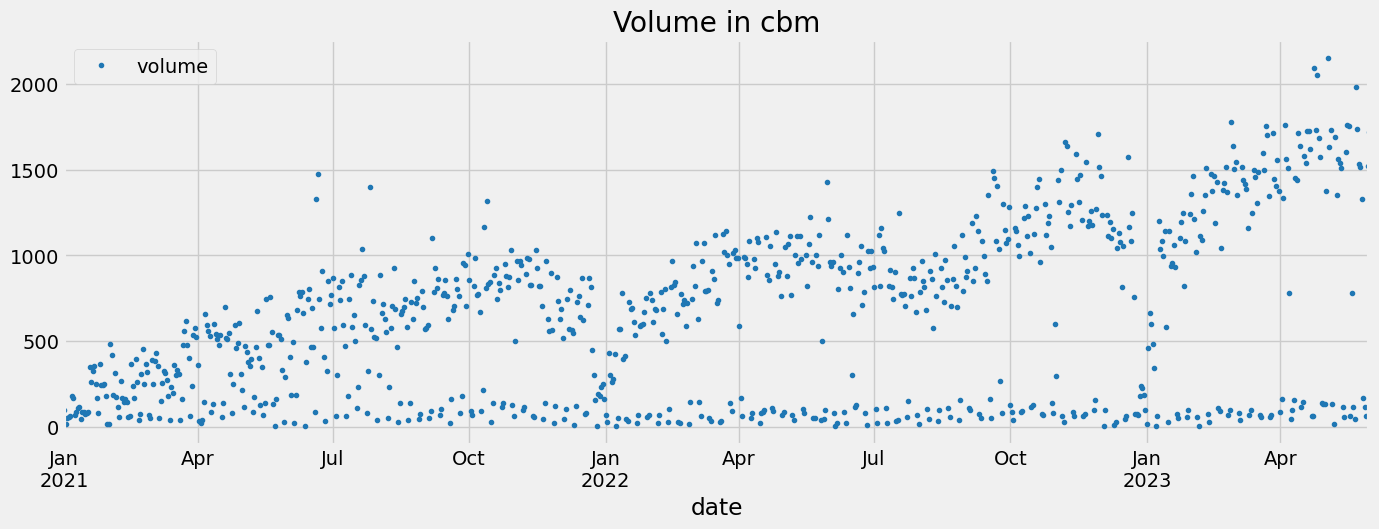

In [9]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Volume in cbm')
plt.show()

<AxesSubplot:xlabel='date'>

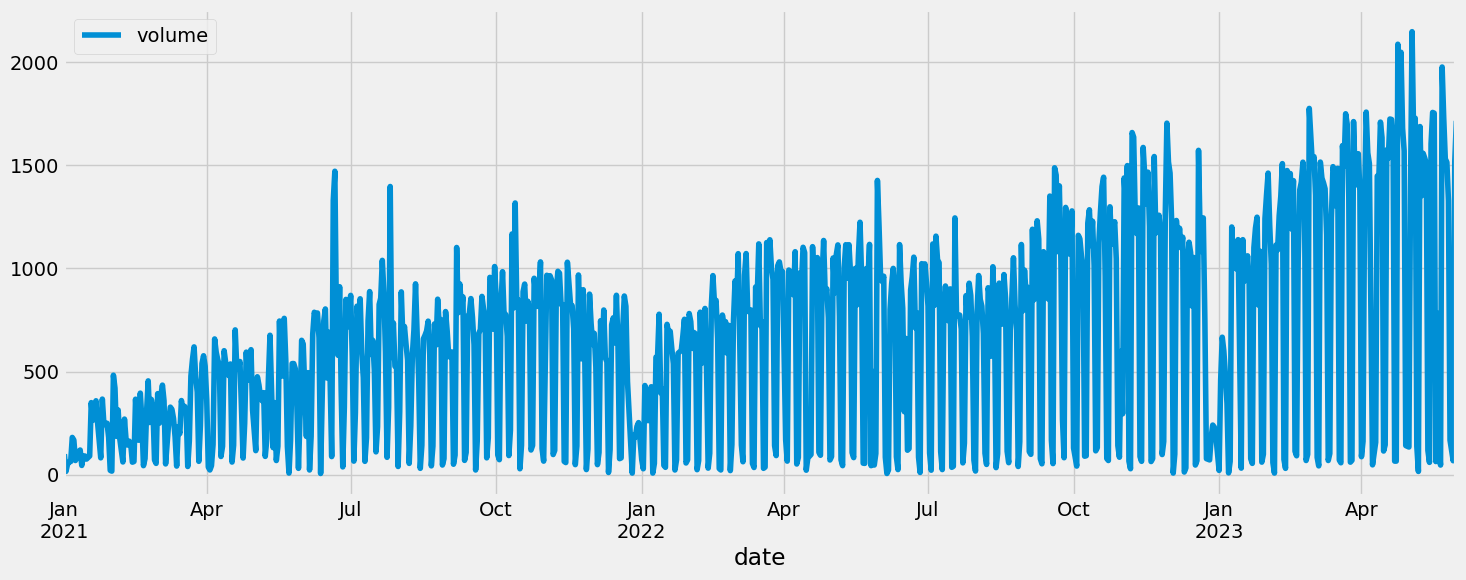

In [10]:
#plt.subplot(111)   #no of rows on y-axis,, 
df['volume'].plot(figsize=(16, 6), legend=True)

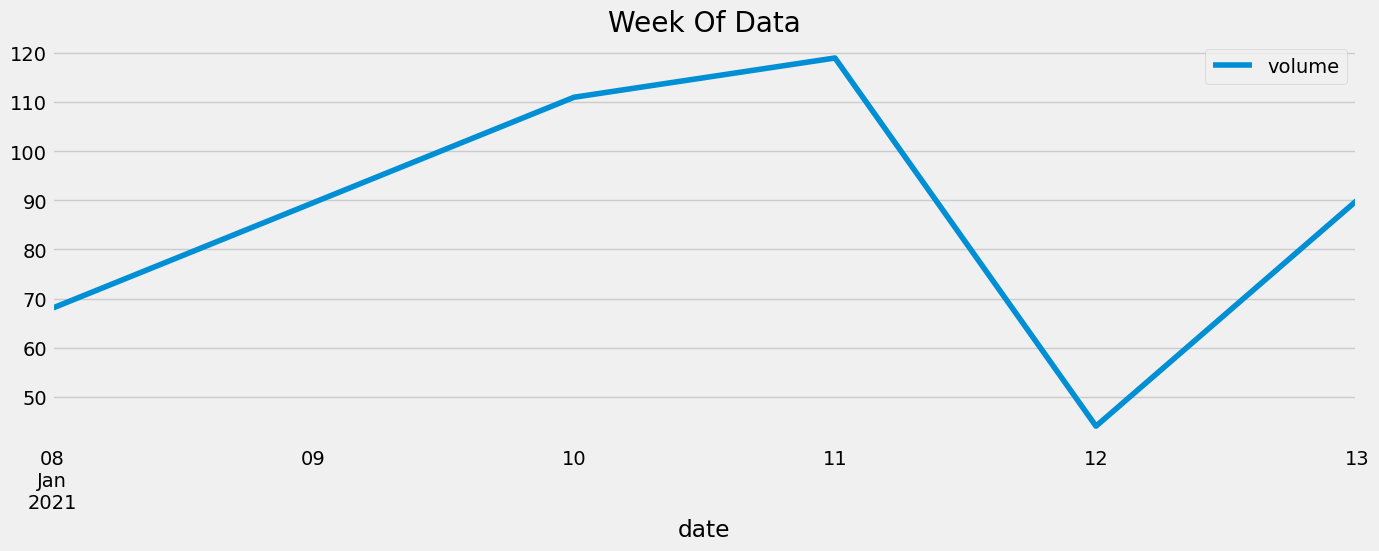

In [11]:
df.loc[(df.index > '01-07-2021') & (df.index < '01-14-2021')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

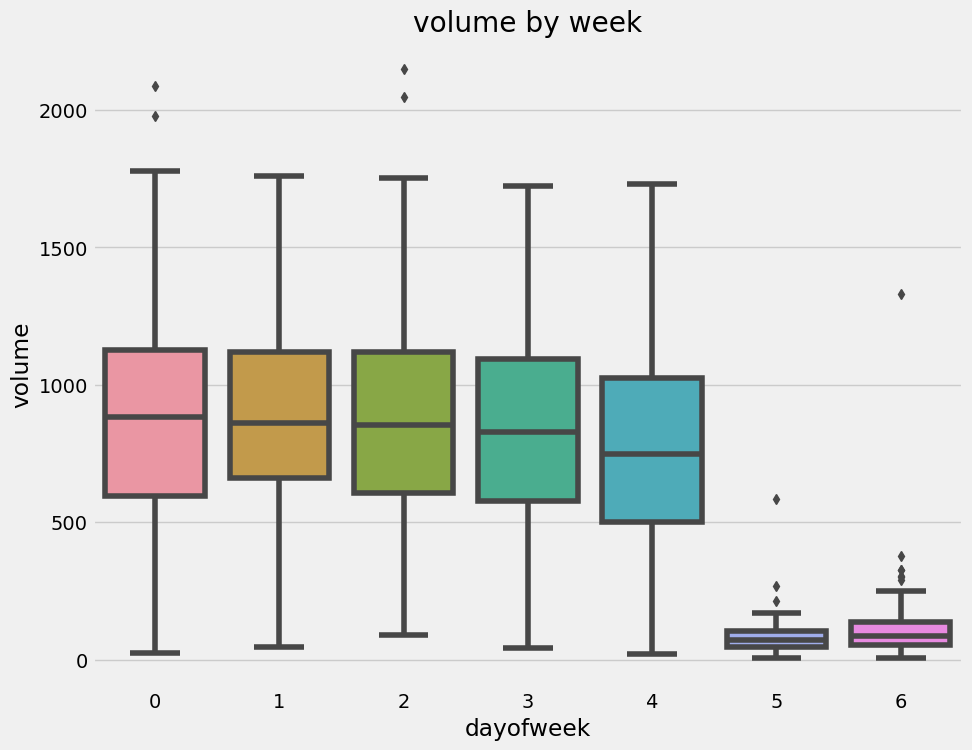

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='volume')
ax.set_title('volume by week')
plt.show()   #monday 0--sunday 6

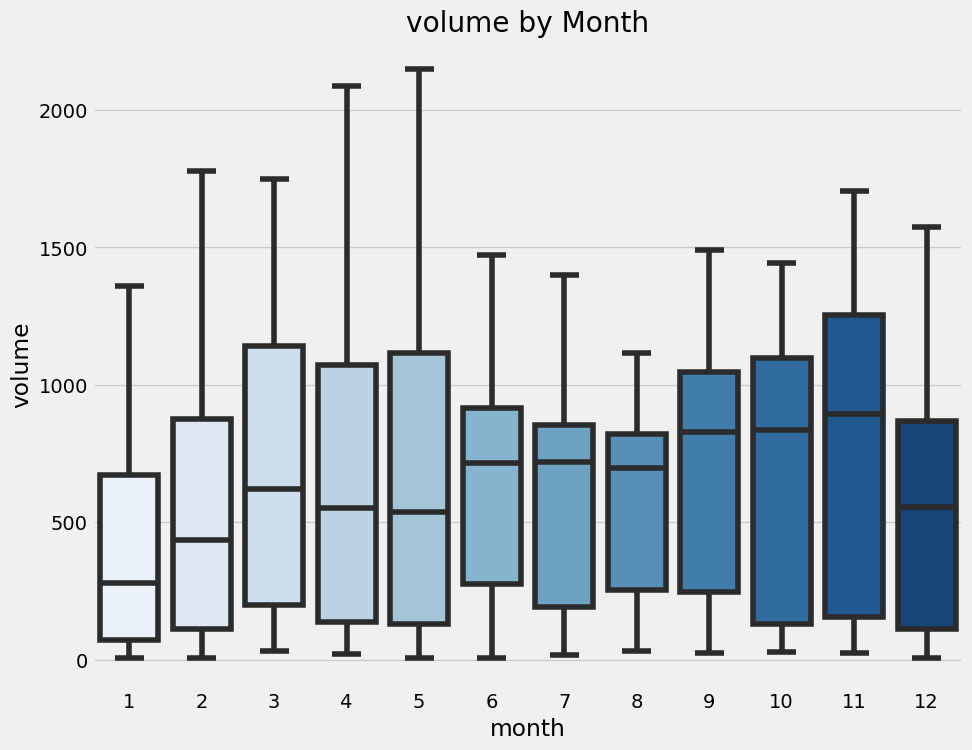

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='volume', palette='Blues')
ax.set_title('volume by Month')
plt.show()

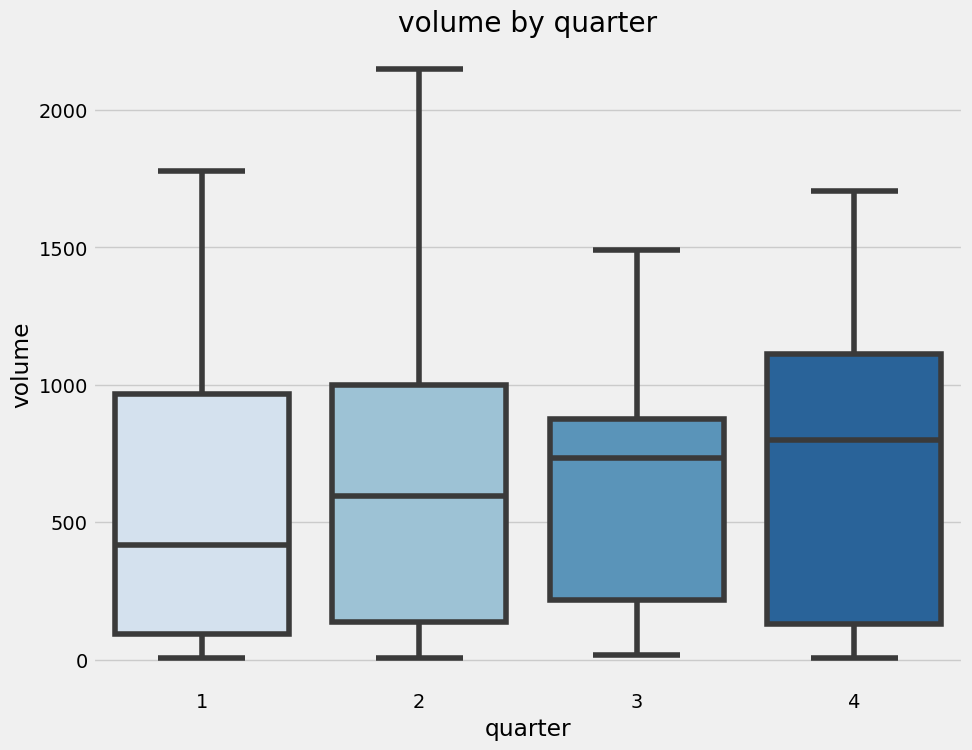

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='volume', palette='Blues')
ax.set_title('volume by quarter')
plt.show()

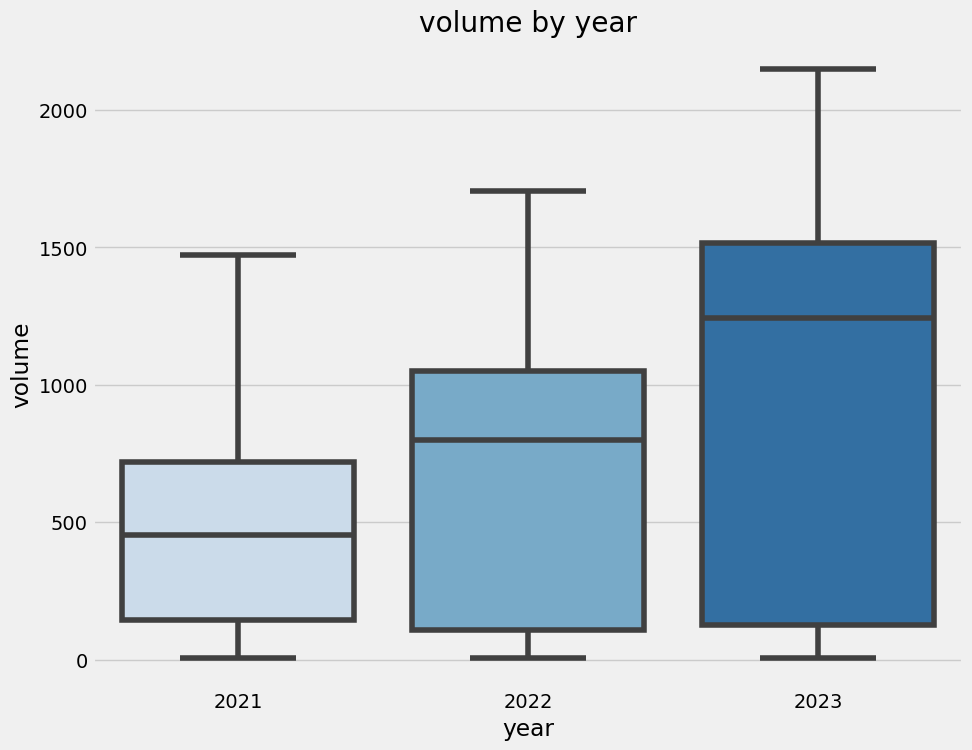

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='volume', palette='Blues')
ax.set_title('volume by year')
plt.show()

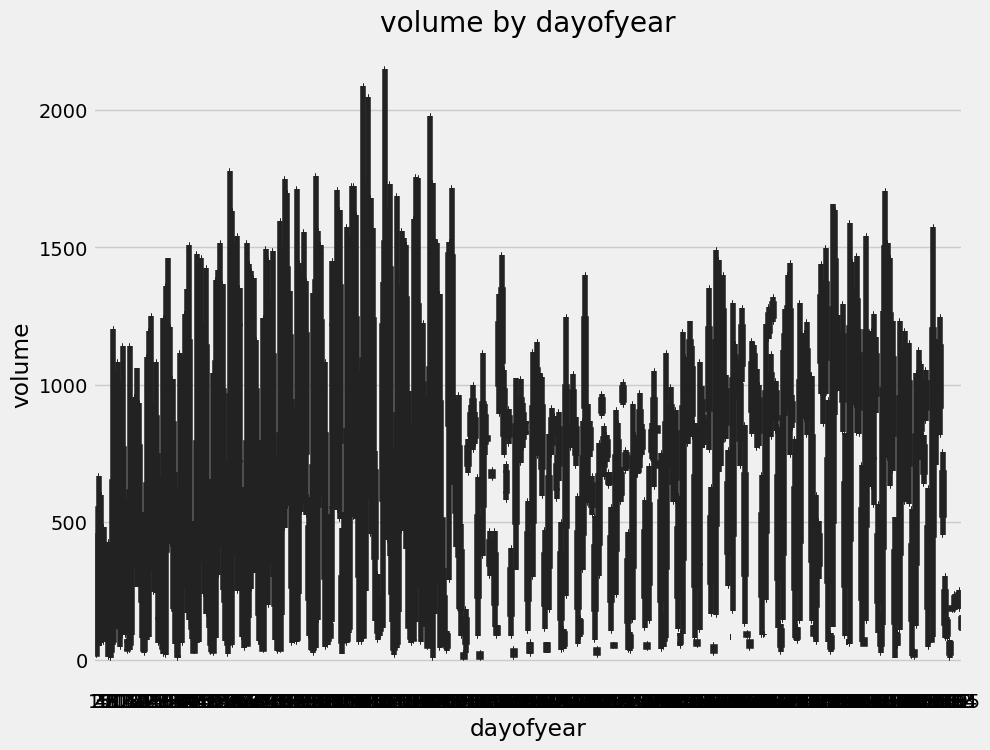

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofyear', y='volume', palette='Blues')
ax.set_title('volume by dayofyear')
plt.show()

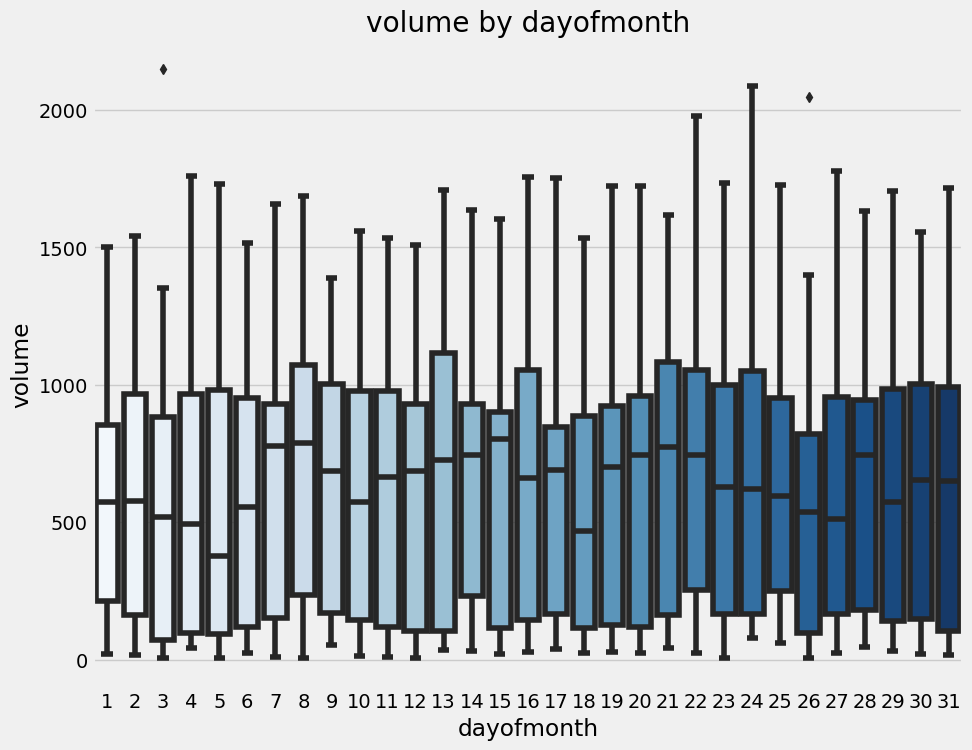

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofmonth', y='volume', palette='Blues')
ax.set_title('volume by dayofmonth')
plt.show()

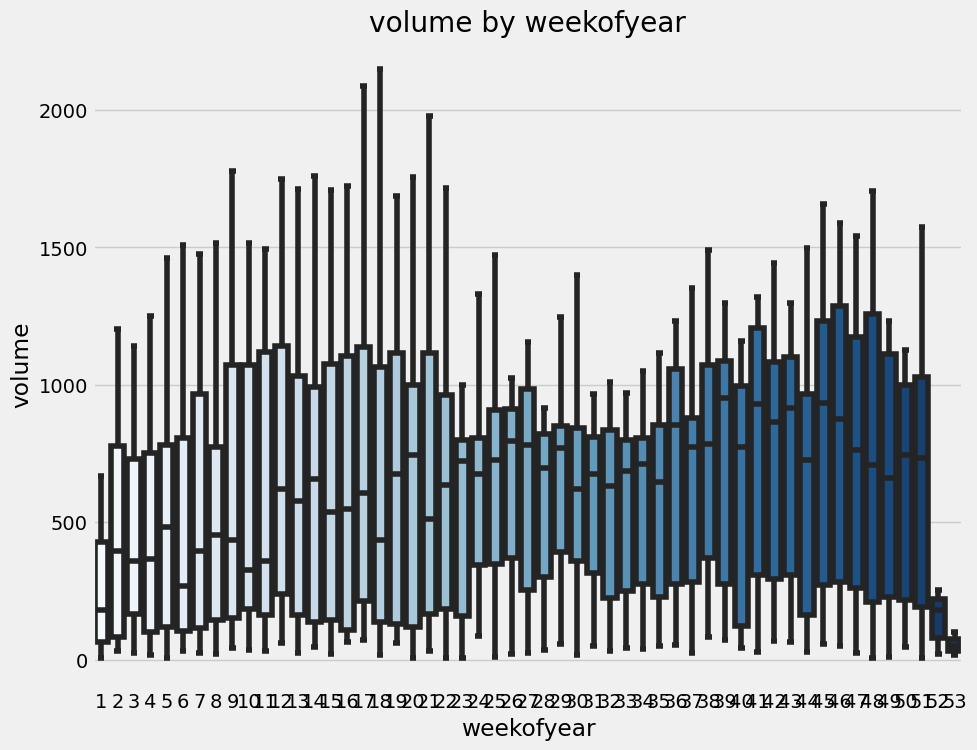

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekofyear', y='volume', palette='Blues')
ax.set_title('volume by weekofyear')
plt.show()

# outliers

<AxesSubplot:ylabel='Frequency'>

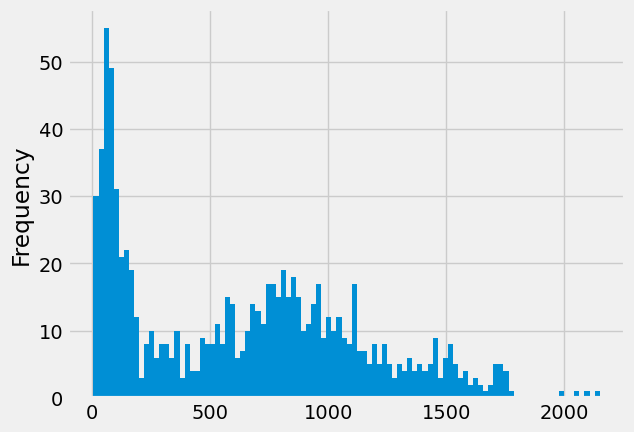

In [20]:
df['volume'].plot(kind='hist', bins=100)

<AxesSubplot:title={'center':'Outliers'}, xlabel='date'>

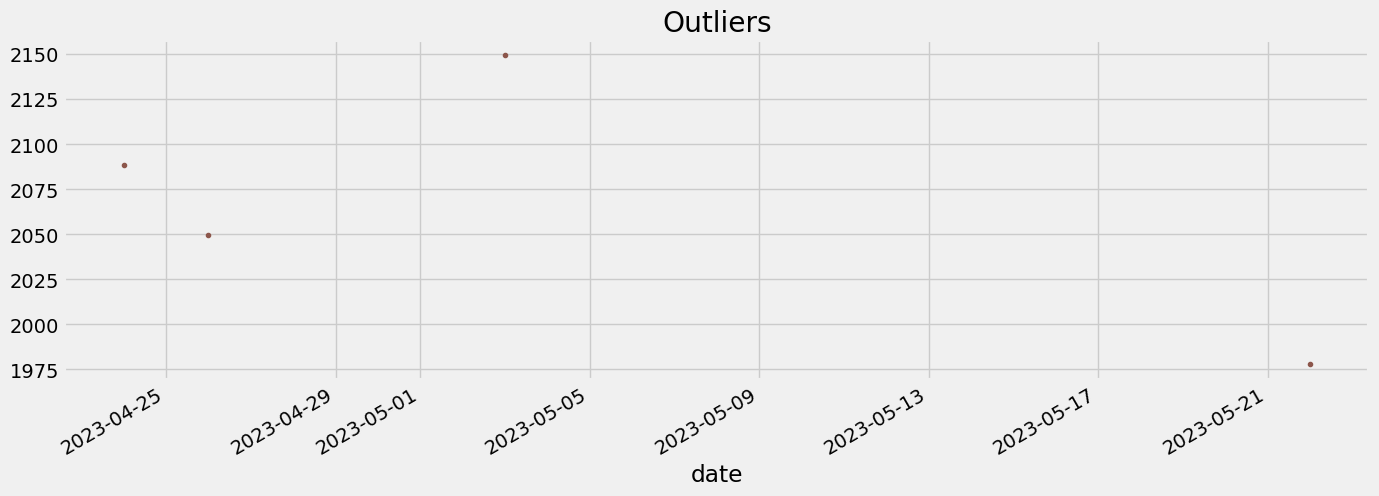

In [21]:
df.query('volume > 1800')['volume'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [22]:
df = df.query('volume < 1800').copy()

<AxesSubplot:ylabel='Frequency'>

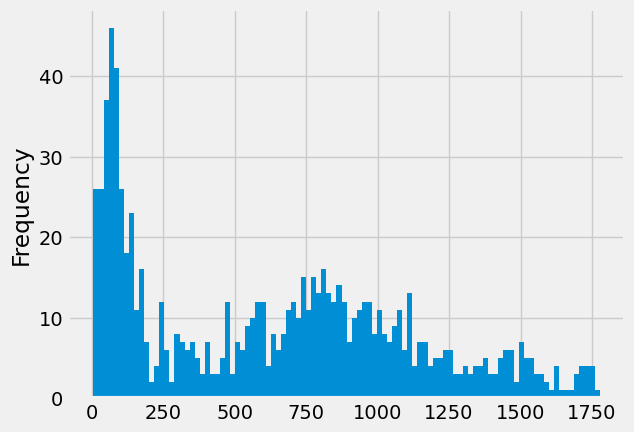

In [23]:
df['volume'].plot(kind='hist', bins=100)

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=7, shuffle=False)
train.columns = df.columns
test.columns = df.columns
print(f"{train.shape[0]} train and {test.shape[0]} test instances")

701 train and 176 test instances


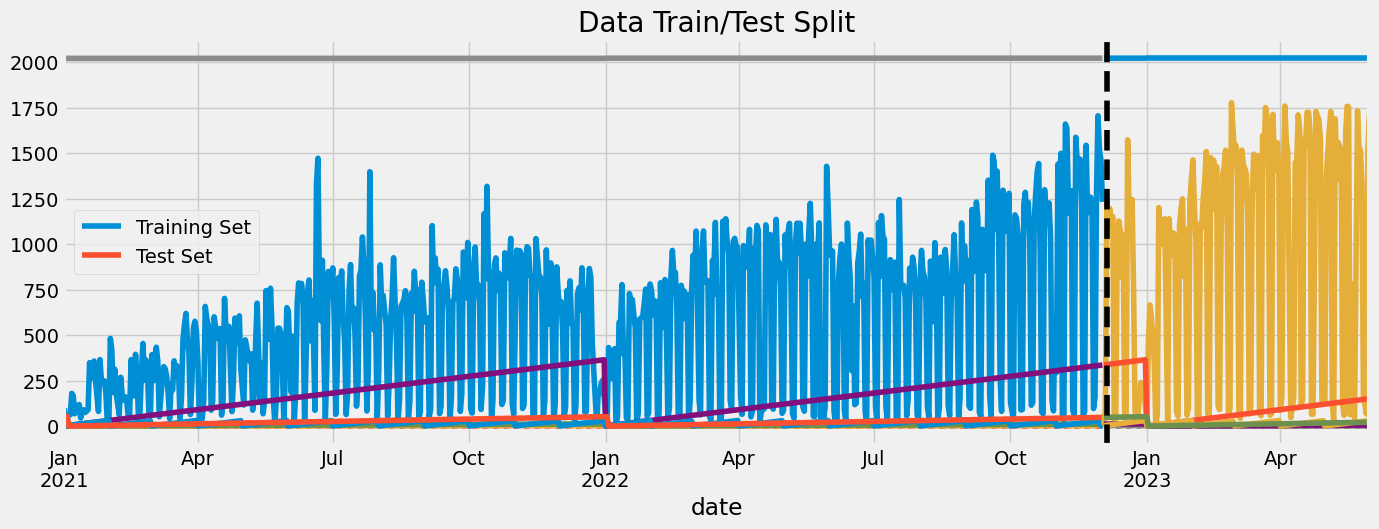

In [25]:
#5th dec 2022
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('12-05-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [26]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
df = df.sort_index()

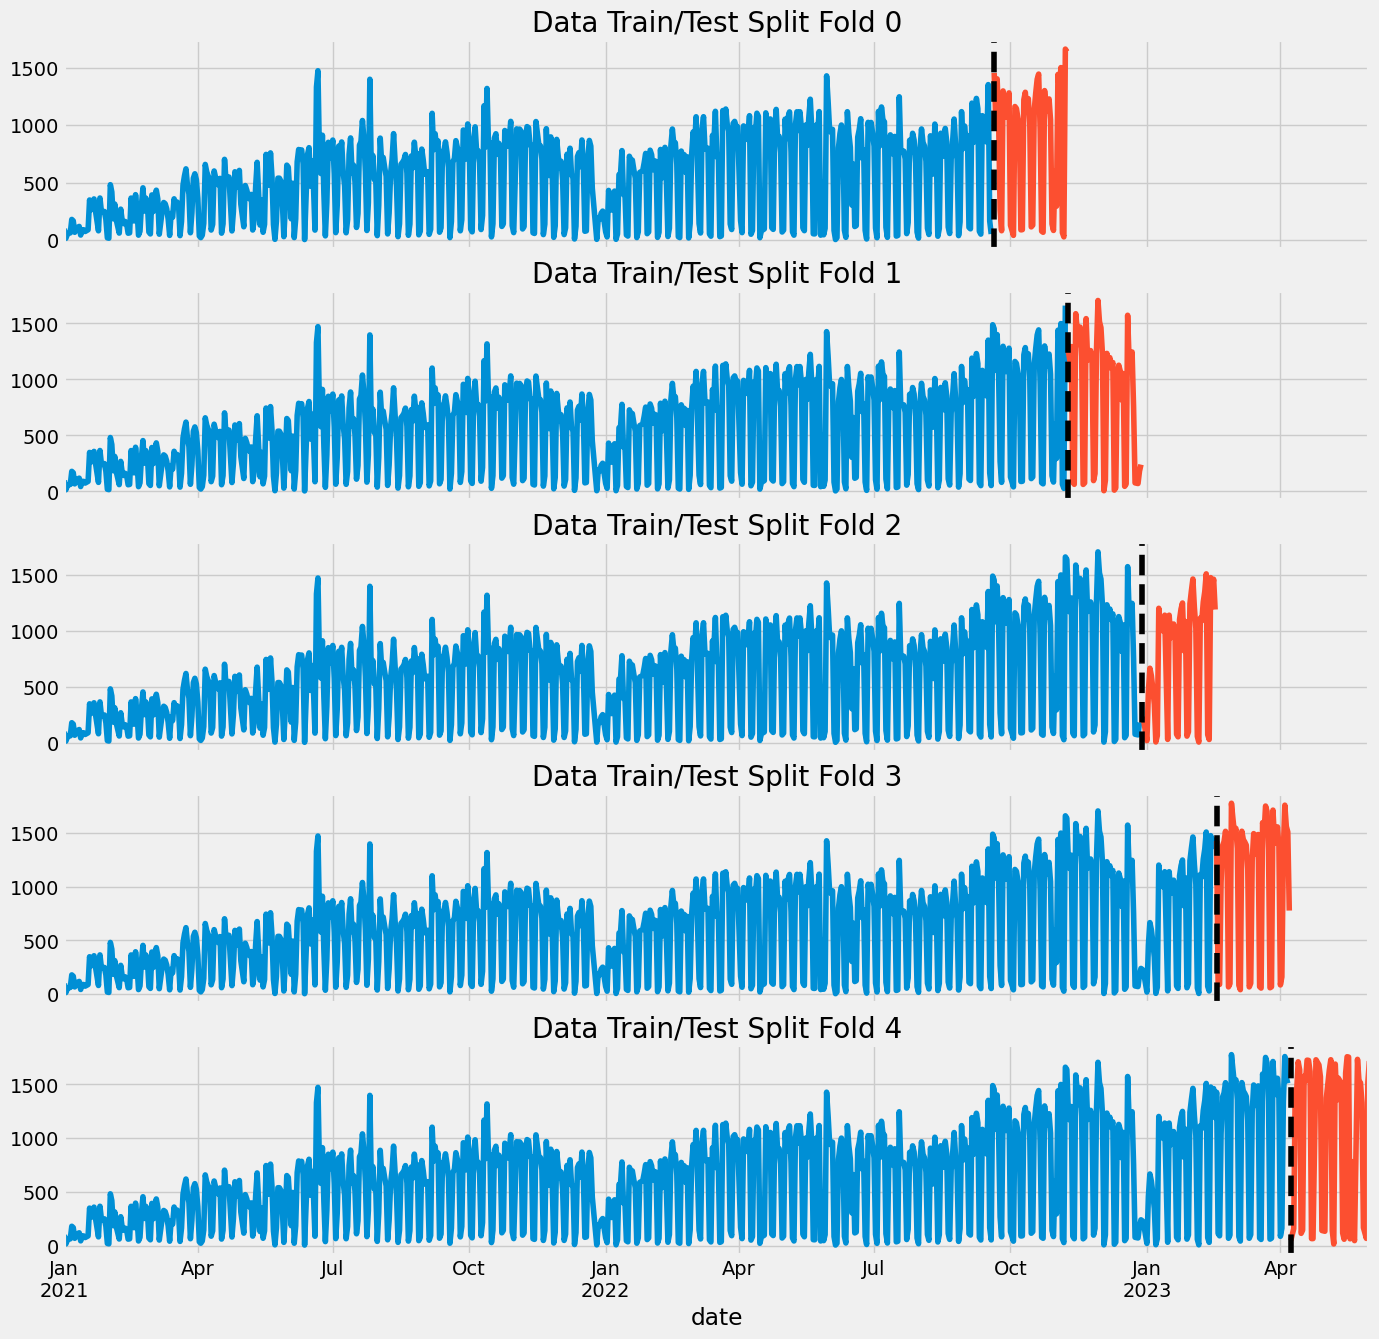

In [27]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['volume'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['volume'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [28]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['year'] = df.index.year
    return df

df = create_features(df)

In [29]:
def add_lags(df):
    target_map = df['volume'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    return df

In [30]:
df = add_lags(df)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def theils_u2(y_true, y_pred):
    numerator = np.sqrt(np.sum((y_pred - y_true)**2) / len(y_true))
    denominator = np.sqrt((np.sum(y_true**2) + np.sum(y_pred**2)) / (2 * len(y_true)))
    return numerator / denominator

# Define the Mean Absolute Percentage Error (MAPE) function
def mean_absolute_percentage_error(y_true, y_pred): 
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100


rmses = []
maes = []
mapes = []
theils_u2_values = []

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofweek','year',
                'lag1']
    TARGET = 'volume'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
  #  -----------------
    rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_value = mean_absolute_error(y_test, y_pred)
    mape_value = mean_absolute_percentage_error(y_test, y_pred)
    u2_value = theils_u2(y_test, y_pred)
    
    rmses.append(rmse_value)
    maes.append(mae_value)
    mapes.append(mape_value)
    theils_u2_values.append(u2_value)


[23:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:631.02188	validation_1-rmse:1011.34113
[100]	validation_0-rmse:305.33688	validation_1-rmse:563.66004
[200]	validation_0-rmse:226.02940	validation_1-rmse:413.20975
[300]	validation_0-rmse:209.22242	validation_1-rmse:374.54551
[400]	validation_0-rmse:203.79745	validation_1-rmse:354.92835
[500]	validation_0-rmse:201.03661	validation_1-rmse:351.90141
[600]	validation_0-rmse:199.11347	validation_1-rmse:351.42401
[603]	validation_0-rmse:199.05920	validation_1-rmse:351.52317
[23:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:665.89452	validation_

In [33]:
y_pred.shape

(50,)

In [34]:
y_test.shape

(50,)

In [35]:
rmses,maes,mapes,theils_u2_values

print(f'RMSES across folds {np.mean(rmses):0.4f}')
print(f'RMSE scores:{rmses}')
print(f'MAES across folds {np.mean(maes):0.4f}')
print(f'MAE scores:{maes}')
print(f'MAPES across folds {np.mean(mapes):0.4f}')
print(f'MAPE scores:{mapes}')
print(f'THEILSU2 across folds {np.mean(theils_u2_values):0.4f}')
print(f'THEILS U2 scores:{theils_u2_values}')

RMSES across folds 334.7200
RMSE scores:[350.2752243855128, 323.42268179170344, 251.76045365884596, 257.81512350695266, 490.32644360076006]
MAES across folds 239.9537
MAE scores:[263.54854415893556, 242.69788665771483, 187.42295455932617, 201.76130325317382, 304.3375831604004]
MAPES across folds 86.1517
MAPE scores:[80.83379804255624, 90.65313302109868, 87.99052376830114, 21.82739813349563, 149.45388026064404]
THEILSU2 across folds 0.3346
THEILS U2 scores:[0.38655673856339573, 0.35137691002355675, 0.2896681806064814, 0.22516307184455206, 0.42048178366709443]


In [36]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 334.7200
Fold scores:[350.2752243855128, 323.42268179170344, 251.76045365884596, 257.81512350695266, 490.32644360076006]


In [37]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofweek', 'year',
            'lag1']
TARGET = 'volume'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[23:30:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:788.40098
[100]	validation_0-rmse:367.29693
[200]	validation_0-rmse:255.35942
[300]	validation_0-rmse:232.54513
[400]	validation_0-rmse:225.49044
[499]	validation_0-rmse:220.88682


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [38]:
df.index.max()

Timestamp('2023-05-31 00:00:00')

In [39]:
# Create future dataframe
future = pd.date_range('06-01-2023','06-30-2023', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [40]:
future_w_features = df_and_future.query('isFuture').copy()

In [41]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

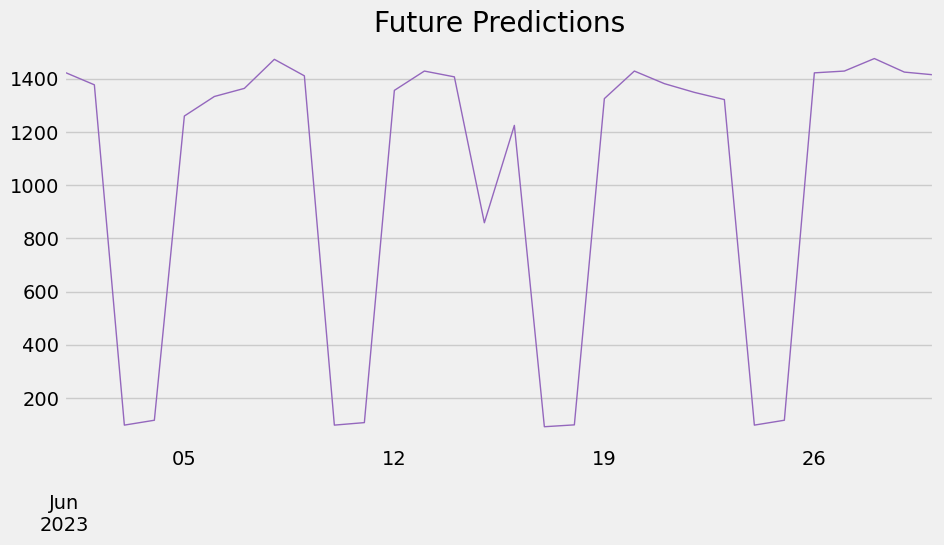

In [42]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [43]:
future_w_features.head(30)

,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,isFuture,pred
2023-06-01,NaN,3,NaN,NaN,2023,NaN,NaN,<NA>,937.0,True,1424.430298
2023-06-02,NaN,4,NaN,NaN,2023,NaN,NaN,<NA>,962.5,True,1376.660645
2023-06-03,NaN,5,NaN,NaN,2023,NaN,NaN,<NA>,84.0,True,98.179276
2023-06-04,NaN,6,NaN,NaN,2023,NaN,NaN,<NA>,5.0,True,116.479622
2023-06-05,NaN,0,NaN,NaN,2023,NaN,NaN,<NA>,22.0,True,1259.405640
2023-06-06,NaN,1,NaN,NaN,2023,NaN,NaN,<NA>,802.0,True,1332.784302
2023-06-07,NaN,2,NaN,NaN,2023,NaN,NaN,<NA>,925.0,True,1363.248169
2023-06-08,NaN,3,NaN,NaN,2023,NaN,NaN,<NA>,1000.5,True,1472.382446
2023-06-09,NaN,4,NaN,NaN,2023,NaN,NaN,<NA>,902.0,True,1410.384521
2023-06-10,NaN,5,NaN,NaN,2023,NaN,NaN,<NA>,86.0,True,98.179276
